In [41]:
import os 
import os.path as osp 
import sys 
from glob import glob 
import warnings

import numpy as np 
import matplotlib.pyplot as plt 
import PIL.Image as Image 
import scipy.ndimage.filters as flt
from skimage import feature 
from scipy.ndimage import gaussian_filter


%matplotlib inline 
%config InlineBackend.figure_format='retina'

plt.rcParams['figure.figsize'] = (9, 6)

In [14]:
root = os.getcwd()
imgLists = glob(osp.join(root, 'data', '*'))

In [15]:
img = Image.open(imgLists[0]).convert("L") # "L" := Load grayscale image 
img = np.array(img)

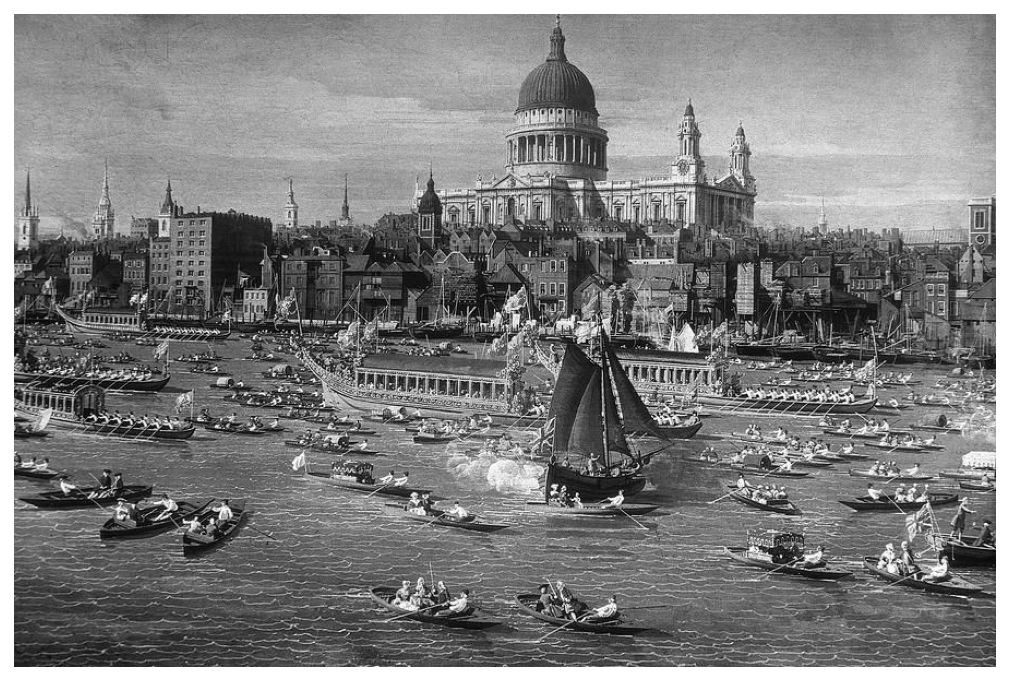

In [31]:
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

***

In [71]:
def anisodiff(img,num_iter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):

    # ...you could always diffuse each color channel independently if you
    # really want
    if img.ndim == 3:
        warnings.warn("Only grayscale images allowed, converting to 2D matrix")
        img = img.mean(2)

    # initialize output array
    img = img.astype('float32')
    imgout = img.copy()

    # initialize some internal variables
    deltaS = np.zeros_like(imgout)
    deltaE = deltaS.copy()
    NS = deltaS.copy()
    EW = deltaS.copy()
    gS = np.ones_like(imgout)
    gE = gS.copy()

    # create the plot figure, if requested
    if ploton:
        import pylab as pl
        from time import sleep

        fig = plt.figure(figsize=(20,5.5),num="Anisotropic diffusion")
        ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

        ax1.imshow(img,interpolation='nearest')
        ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
        ax1.set_title("Original image")
        ax2.set_title("Iteration 0")

        fig.canvas.draw()

    for ii in range(1,num_iter):

        # calculate the diffs
        deltaS[:-1,: ] = np.diff(imgout,axis=0)
        deltaE[: ,:-1] = np.diff(imgout,axis=1)

        if 0<sigma:
            deltaSf=flt.gaussian_filter(deltaS,sigma);
            deltaEf=flt.gaussian_filter(deltaE,sigma);
        else: 
            deltaSf=deltaS;
            deltaEf=deltaE;

        # conduction gradients (only need to compute one per dim!)
        if option == 1:
            gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
            gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
        elif option == 2:
            gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
            gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

        # update matrices
        E = gE*deltaE
        S = gS*deltaS

        # subtract a copy that has been shifted 'North/West' by one
        # pixel. don't as questions. just do it. trust me.
        NS[:] = S
        EW[:] = E
        NS[1:,:] -= S[:-1,:]
        EW[:,1:] -= E[:,:-1]

        # update the image
        imgout += gamma*(NS+EW)

        if ploton:
            iterstring = "Iteration %i" %(ii+1)
            ih.set_data(imgout)
            ax2.set_title(iterstring)
            fig.canvas.draw()
            # sleep(0.01)

    return imgout


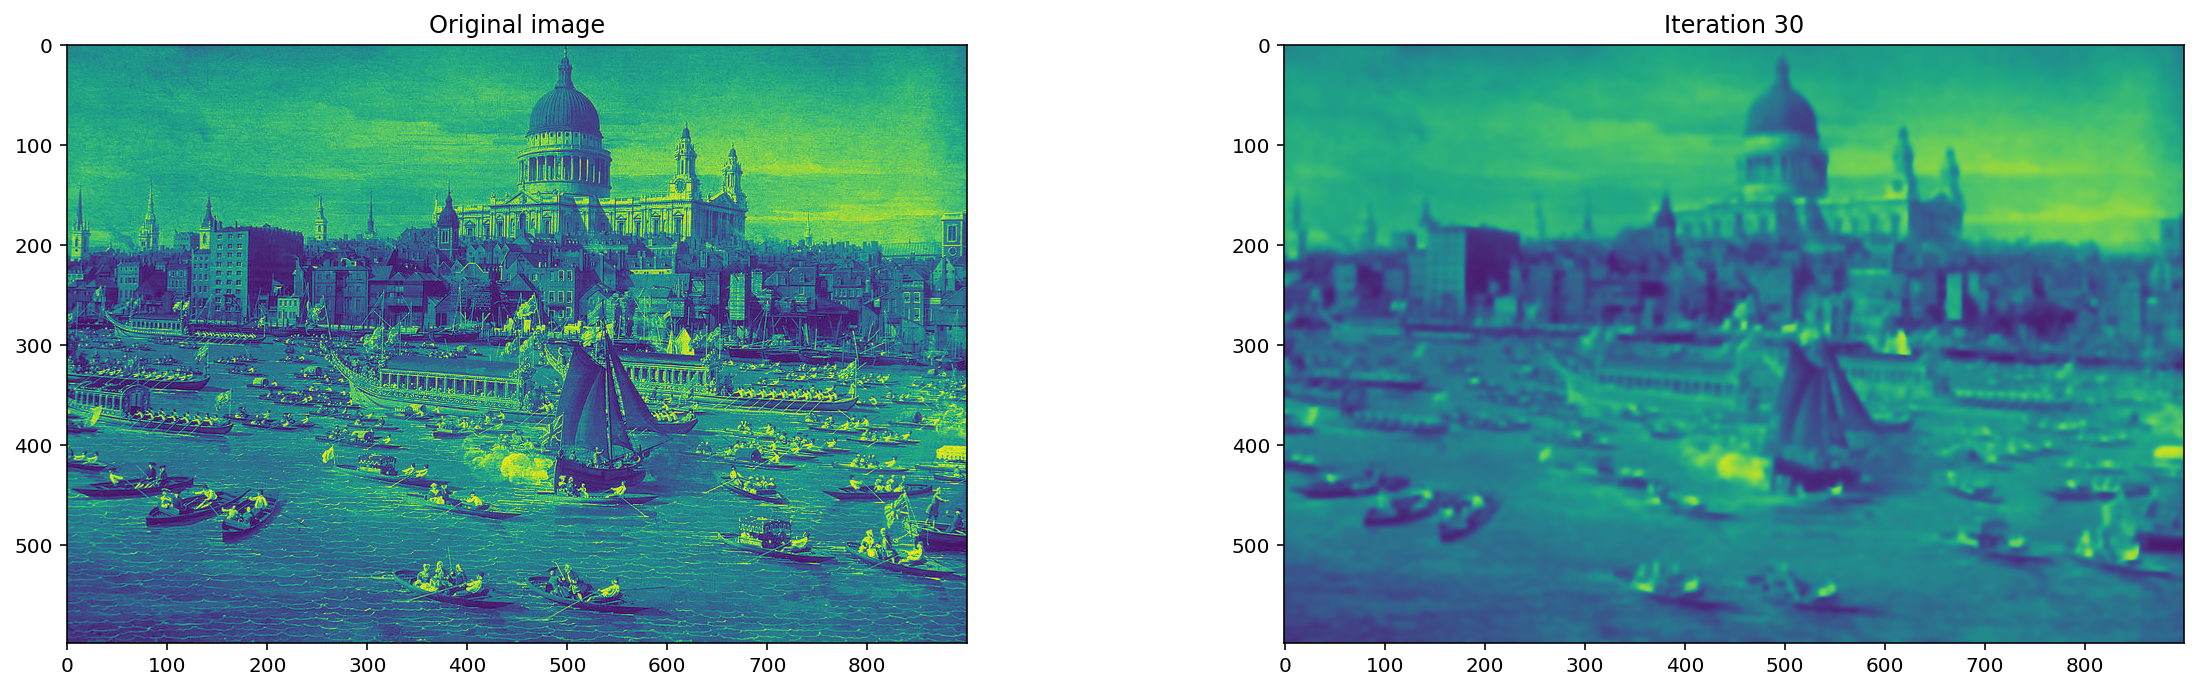

In [107]:
fimg = anisodiff(img,num_iter=30,kappa=15,gamma=0.15,step=(1,1),sigma=2.5,option=1, ploton=True)

***

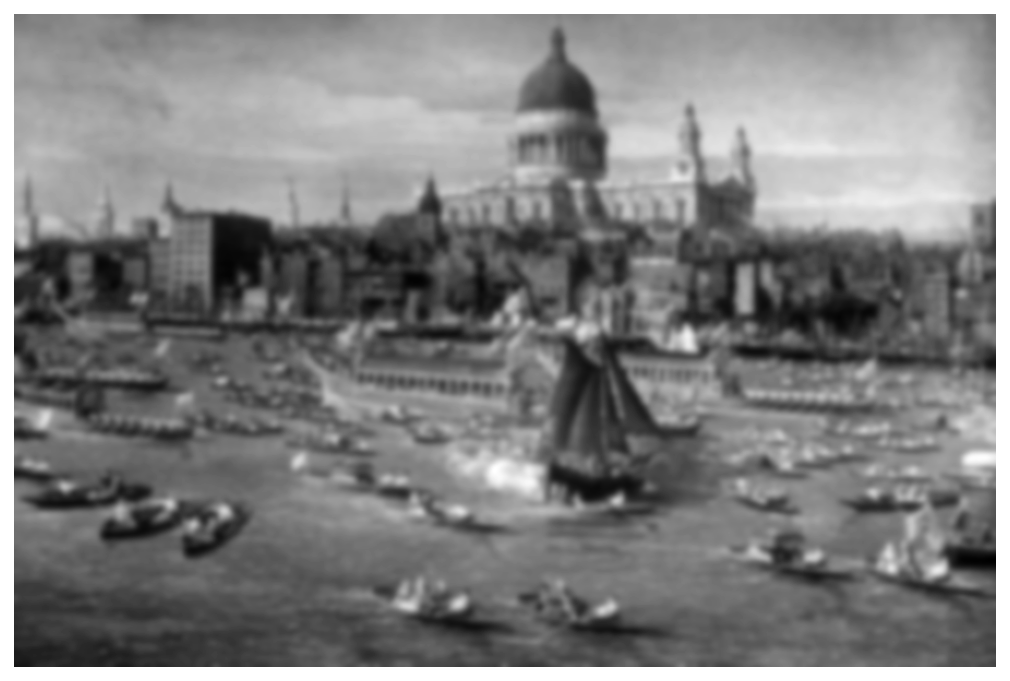

In [108]:
gaussian_img = gaussian_filter(img, sigma=3)

plt.axis("off")
plt.imshow(gaussian_img, cmap="gray")
plt.show()

In [109]:
edges0 = feature.canny(img)
edges1 = feature.canny(fimg)
edges2 = feature.canny(gaussian_img)

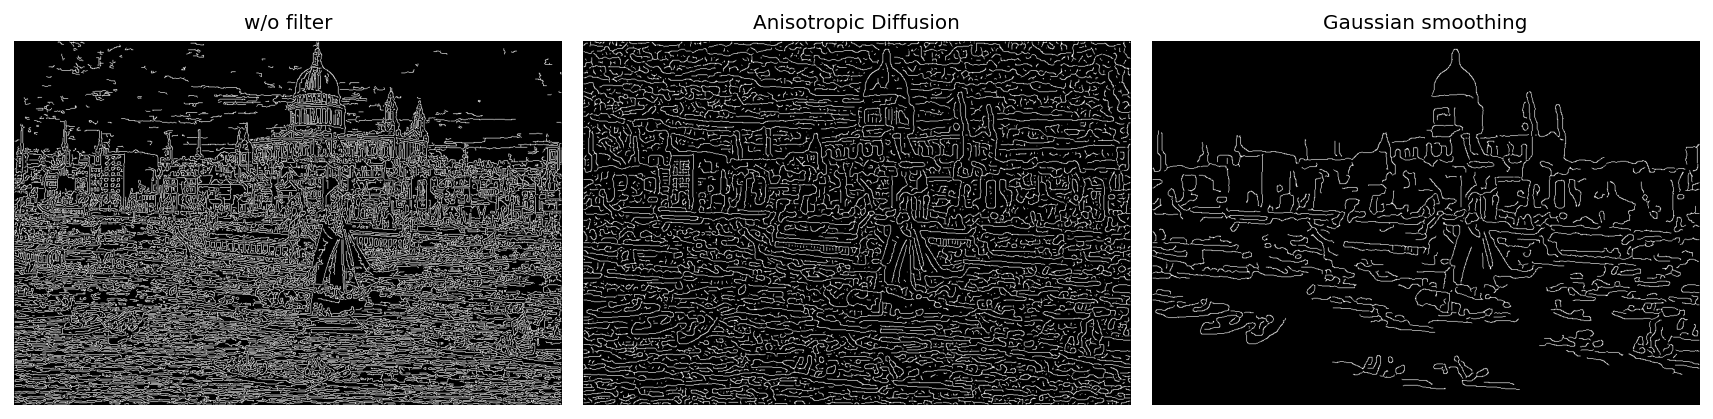

In [110]:
# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 6),
                                    sharex=True, sharey=True)

ax1.imshow(edges0, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('w/o filter', fontsize=10)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Anisotropic Diffusion', fontsize=10)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Gaussian smoothing', fontsize=10)

fig.tight_layout()

plt.show()

***

In [111]:
from medpy.filter.smoothing import anisotropic_diffusion

In [112]:
after_img = anisotropic_diffusion(img, niter=30, kappa=15, gamma=0.14)

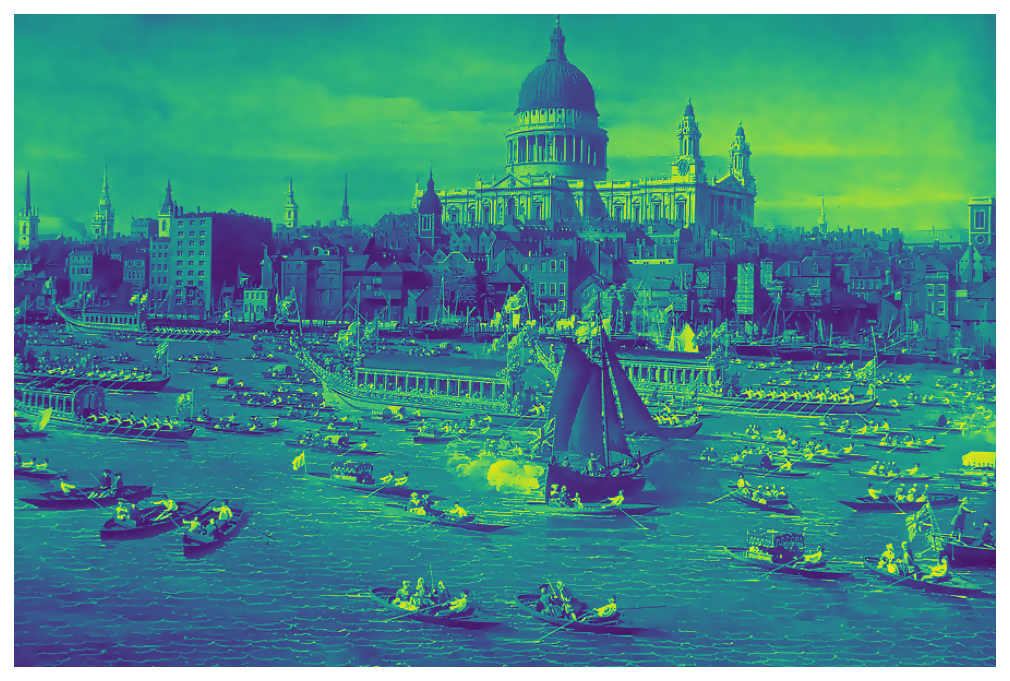

In [113]:
plt.axis("off")
plt.imshow(after_img)
plt.show()

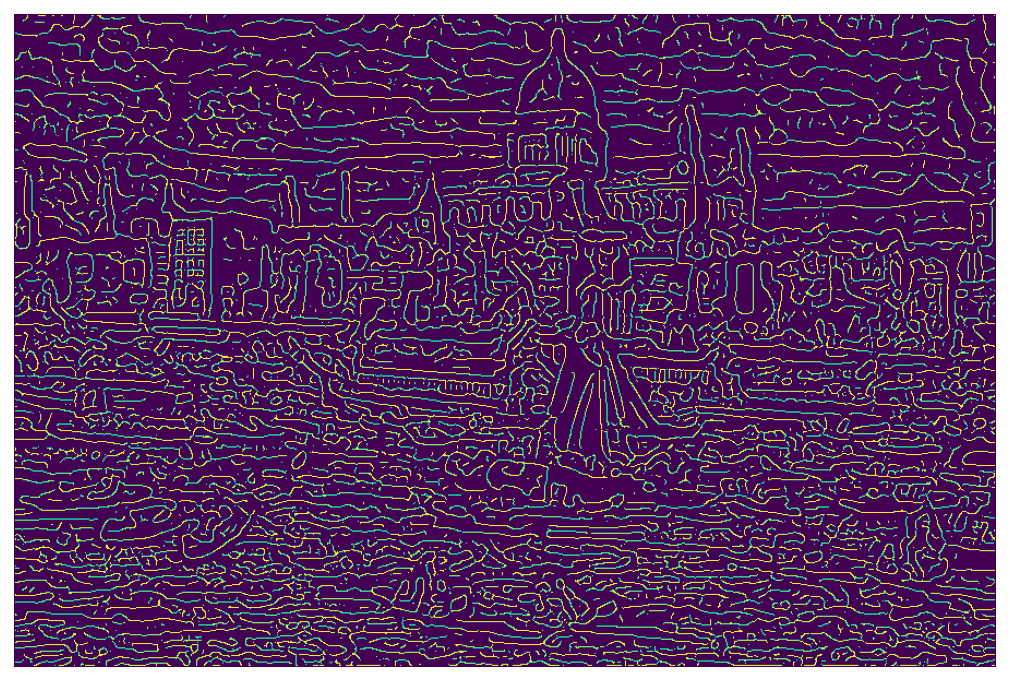

In [114]:
edges = feature.canny(after_img, sigma=3)

plt.axis("off")
plt.imshow(edges)
plt.show()